In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
from PIL import Image
import joblib

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)

In [2]:
ROOT_DIR = "dataset/fruit360"
TRAIN_DIR = os.path.join(ROOT_DIR, "Training")
TEST_DIR = os.path.join(ROOT_DIR, "Test")

class Fruit360FolderDataset(Dataset):
    def __init__(self, root_dir, transform=None, variety=False):
        self.root_dir = root_dir
        self.transform = transform
        self.variety = variety
        self.samples = []
        
        for class_name in sorted(os.listdir(root_dir)):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            label = class_name if self.variety else class_name.split()[0]
            for img_name in os.listdir(class_dir):
                if img_name.lower().endswith(('.jpg', '.png')):
                    self.samples.append((os.path.join(class_dir, img_name), label))
        
        unique_labels = sorted({lbl for _, lbl in self.samples})
        self.label_to_idx = {lbl: i for i, lbl in enumerate(unique_labels)}
        self.idx_to_label = {i: lbl for i, lbl in self.label_to_idx.items()}
        
        print(f"{os.path.basename(root_dir)}: {len(self.samples)} images, {len(unique_labels)} classes")
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        img_path, label_str = self.samples[idx]
        img = Image.open(img_path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, label_str

SIZE = 32
transform_32 = T.Compose([
    T.Resize((SIZE, SIZE)),
    T.ToTensor(),
])

BATCH_SIZE = 100

train_dataset_32 = Fruit360FolderDataset(TRAIN_DIR, transform=transform_32, variety=False)
train_loader_32 = DataLoader(train_dataset_32, batch_size=BATCH_SIZE, shuffle=True)

test_dataset_32 = Fruit360FolderDataset(TEST_DIR, transform=transform_32, variety=False)
test_loader_32 = DataLoader(test_dataset_32, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train loader 32x32: {len(train_dataset_32)} images, {len(train_loader_32)} batches")
print(f"Test loader 32x32: {len(test_dataset_32)} images, {len(test_loader_32)} batches")

Training: 130344 images, 79 classes
Test: 43442 images, 79 classes
Train loader 32x32: 130344 images, 1304 batches
Test loader 32x32: 43442 images, 435 batches


In [3]:
def extract_hsv_histogram(img_tensor, bins=16):
    """
    Extract HSV histogram features from an image tensor.
    img_tensor: torch tensor of shape (3, H, W) with values in [0, 1]
    Returns: numpy array of shape (48,) - 16 bins for each of H, S, V channels
    """
    # Convert tensor to numpy and transpose to (H, W, 3)
    img_np = img_tensor.numpy().transpose(1, 2, 0)
    
    # Convert RGB to HSV (img_np is in [0, 1], need to convert to [0, 255] first)
    img_uint8 = (img_np * 255).astype(np.uint8)
    from cv2 import cvtColor, COLOR_RGB2HSV
    hsv = cvtColor(img_uint8, COLOR_RGB2HSV)
    
    # Extract H, S, V channels
    h_channel = hsv[:, :, 0].astype(np.float32) / 180.0  # H in [0, 180] -> normalize to [0, 1]
    s_channel = hsv[:, :, 1].astype(np.float32) / 255.0  # S in [0, 255]
    v_channel = hsv[:, :, 2].astype(np.float32) / 255.0  # V in [0, 255]
    
    # Compute histograms
    h_hist, _ = np.histogram(h_channel, bins=bins, range=(0, 1))
    s_hist, _ = np.histogram(s_channel, bins=bins, range=(0, 1))
    v_hist, _ = np.histogram(v_channel, bins=bins, range=(0, 1))
    
    # Normalize and concatenate
    h_hist = h_hist / (h_hist.sum() + 1e-6)
    s_hist = s_hist / (s_hist.sum() + 1e-6)
    v_hist = v_hist / (v_hist.sum() + 1e-6)
    
    feature_vector = np.concatenate([h_hist, s_hist, v_hist])
    return feature_vector

# Test the function
print("Testing HSV extraction on a sample image...")
test_img, _ = test_dataset_32[0]
test_features = extract_hsv_histogram(test_img, bins=16)
print(f"Feature vector shape: {test_features.shape}")
print(f"Feature vector (first 10 elements): {test_features[:10]}")

Testing HSV extraction on a sample image...
Feature vector shape: (48,)
Feature vector (first 10 elements): [0.77148437 0.15917969 0.015625   0.00097656 0.00097656 0.00390625
 0.         0.         0.0234375  0.        ]


In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

print("Extracting HSV features from training dataset...")
X_train = []
y_train = []

start_extraction = time.time()
for imgs, labels_str in train_loader_32:
    for img, lbl_str in zip(imgs, labels_str):
        features = extract_hsv_histogram(img, bins=16)
        X_train.append(features)
        y_train.append(train_dataset_32.label_to_idx[lbl_str])

X_train = np.array(X_train)
y_train = np.array(y_train)
extraction_time = time.time() - start_extraction

print(f"Extracted {len(X_train)} training samples in {extraction_time:.2f}s")
print(f"Feature matrix shape: {X_train.shape}")
print(f"Unique classes: {len(np.unique(y_train))}")

print("\nTraining scaler...")
scaler_hsv = StandardScaler()
X_train_scaled = scaler_hsv.fit_transform(X_train)

print("Training SVM classifier (RBF kernel)...")
start_train = time.time()
svm_hsv = SVC(kernel='rbf', C=1.0, gamma='scale', verbose=0)
svm_hsv.fit(X_train_scaled, y_train)
train_time = time.time() - start_train

print(f"SVM training completed in {train_time:.2f}s")

# Calculate training accuracy
train_acc = svm_hsv.score(X_train_scaled, y_train)
print(f"Training accuracy: {train_acc:.4f}")

print("\nSaving scaler and SVM model...")
joblib.dump(scaler_hsv, "saved_models/scaler_hsv_16bins_32x32.joblib")
joblib.dump(svm_hsv, "saved_models/svm_hsv_16bins_32x32.joblib")
print("Saved to saved_models/")

Extracting HSV features from training dataset...
Extracted 130344 training samples in 72.45s
Feature matrix shape: (130344, 48)
Unique classes: 79

Training scaler...
Training SVM classifier (RBF kernel)...
SVM training completed in 76.14s
Training accuracy: 0.9970

Saving scaler and SVM model...
Saved to saved_models/


In [5]:
def clamp_01(x):
    return torch.clamp(x, 0.0, 1.0)

def add_color_patches(x, num_patches, color, alpha_range=(0.4, 0.7), size_range=(0.05, 0.15)):
    _, H, W = x.shape
    out = x.clone()
    for _ in range(num_patches):
        s = np.random.uniform(size_range[0], size_range[1])
        patch_area = s * H * W / 4
        r = np.random.uniform(0.5, 1.5)
        patch_h = int(math.sqrt(patch_area / r))
        patch_w = int(math.sqrt(patch_area * r))
        patch_h = max(1, min(H, patch_h))
        patch_w = max(1, min(W, patch_w))
        top = np.random.randint(0, H - patch_h + 1)
        left = np.random.randint(0, W - patch_w + 1)
        bottom = top + patch_h
        right = left + patch_w
        alpha = np.random.uniform(alpha_range[0], alpha_range[1])
        patch = out[:, top:bottom, left:right]
        blended = alpha * color + (1 - alpha) * patch
        out[:, top:bottom, left:right] = blended
    return clamp_01(out)

def add_occlusion_patch(x, area_ratio=0.1, color=torch.tensor([0.5, 0.5, 0.5]).view(3,1,1), alpha=0.5):
    _, H, W = x.shape
    out = x.clone()
    patch_area = area_ratio * H * W
    r = np.random.uniform(0.5, 1.5)
    patch_h = int(math.sqrt(patch_area / r))
    patch_w = int(math.sqrt(patch_area * r))
    patch_h = max(1, min(H, patch_h))
    patch_w = max(1, min(W, patch_w))
    top = np.random.randint(0, H - patch_h + 1)
    left = np.random.randint(0, W - patch_w + 1)
    bottom = top + patch_h
    right = left + patch_w
    patch = out[:, top:bottom, left:right]
    blended = alpha * color + (1 - alpha) * patch
    out[:, top:bottom, left:right] = blended
    return clamp_01(out)

color_dirt = torch.tensor([0.3, 0.25, 0.2]).view(3,1,1)
color_bruise = torch.tensor([0.25, 0.2, 0.15]).view(3,1,1)

def noise_mild(x):
    return clamp_01(x + torch.randn_like(x) * 0.025)

def dark_mild(x):
    return clamp_01(x * 0.65)

def overexposed_mild(x):
    return clamp_01(x * 1.35)

def dirty_mild(x):
    return add_color_patches(x, num_patches=2, color=color_dirt, alpha_range=(0.5, 0.8), size_range=(0.03, 0.08))

def bruised_mild(x):
    return add_color_patches(x, num_patches=1, color=color_bruise, alpha_range=(0.4, 0.7), size_range=(0.03, 0.08))

def occlusion_small(x):
    return add_occlusion_patch(x, area_ratio=0.10, alpha=0.5)

blur_medium = T.GaussianBlur(kernel_size=5, sigma=1.0)

def scenario_A(x):
    x = blur_medium(x)
    x = noise_mild(x)
    if np.random.rand() < 0.7:
        x = dirty_mild(x)
    return x

def scenario_B(x):
    if np.random.rand() < 0.5:
        x = dark_mild(x)
    else:
        x = overexposed_mild(x)
    x = noise_mild(x)
    return x

def scenario_C(x):
    x = occlusion_small(x)
    if np.random.rand() < 0.5:
        x = bruised_mild(x)
    else:
        x = dirty_mild(x)
    return x

scenario_fns = {
    "scenario_A": scenario_A,
    "scenario_B": scenario_B,
    "scenario_C": scenario_C,
}

scenarios_mixed = {
    "clean": lambda x: x,
    "scenario_A": scenario_A,
    "scenario_B": scenario_B,
    "scenario_C": scenario_C,
}

print(list(scenarios_mixed.keys()))

['clean', 'scenario_A', 'scenario_B', 'scenario_C']


In [6]:
from sklearn.metrics import classification_report

def evaluate_mixed_scenarios_hsv(test_loader, scenario_fns, probs, seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    scenario_names = list(scenario_fns.keys())
    
    all_preds = []
    all_labels_idx = []
    scenario_counts = {name: 0 for name in scenario_names}
    
    start = time.time()
    
    for imgs, labels_str in test_loader:
        imgs_batch = []
        labels_idx_batch = []
        for img, lbl_str in zip(imgs, labels_str):
            r = np.random.rand()
            if r < probs[0]:
                scenario = scenario_names[0]      # 'clean'
            elif r < probs[0] + probs[1]:
                scenario = scenario_names[1]      # 'scenario_A'
            elif r < probs[0] + probs[1] + probs[2]:
                scenario = scenario_names[2]      # 'scenario_B'
            else:
                scenario = scenario_names[3]      # 'scenario_C'
            
            scenario_counts[scenario] += 1
            x = scenario_fns[scenario](img)
            imgs_batch.append(x.unsqueeze(0))
            labels_idx_batch.append(test_dataset_32.label_to_idx[lbl_str])
        
        imgs_batch = torch.cat(imgs_batch, dim=0)
        
        # Extract HSV features
        X_batch = []
        for i in range(imgs_batch.shape[0]):
            features = extract_hsv_histogram(imgs_batch[i], bins=16)
            X_batch.append(features)
        
        X_batch = np.array(X_batch)
        X_batch = scaler_hsv.transform(X_batch)
        preds = svm_hsv.predict(X_batch)
        
        all_preds.extend(preds)
        all_labels_idx.extend(labels_idx_batch)
    
    all_preds = np.array(all_preds)
    all_labels_idx = np.array(all_labels_idx)
    acc = (all_preds == all_labels_idx).mean()
    elapsed = time.time() - start
    
    return acc, elapsed, scenario_counts, all_labels_idx, all_preds

probs_distribution = [0.60, 0.15, 0.15, 0.10]

print("Testing 32x32 HSV on mixed realistic distribution (60% clean / 15% A / 15% B / 10% C)...")
acc_mixed, time_mixed, counts_mixed, y_true_mixed, y_pred_mixed = evaluate_mixed_scenarios_hsv(
    test_loader_32,
    scenarios_mixed,
    probs_distribution,
    seed=RANDOM_STATE,
)

print(f"\nAccuracy on mixed test: {acc_mixed:.4f}")
print(f"Time: {time_mixed:.2f}s")
print(f"Scenario distribution (actual): {counts_mixed}")

idx_to_label_fixed = {idx: lbl for lbl, idx in test_dataset_32.label_to_idx.items()}
target_names = [idx_to_label_fixed[i] for i in range(len(idx_to_label_fixed))]

print("\nClassification report on mixed test (per class and averages):")
print(classification_report(
    y_true_mixed,
    y_pred_mixed,
    target_names=target_names,
    digits=4
))

Testing 32x32 HSV on mixed realistic distribution (60% clean / 15% A / 15% B / 10% C)...

Accuracy on mixed test: 0.8036
Time: 262.17s
Scenario distribution (actual): {'clean': 26070, 'scenario_A': 6650, 'scenario_B': 6421, 'scenario_C': 4301}

Classification report on mixed test (per class and averages):
              precision    recall  f1-score   support

     Almonds     1.0000    0.6753    0.8062        77
       Apple     0.6883    0.8745    0.7703      5506
     Apricot     0.9916    0.7195    0.8339       164
     Avocado     0.9451    0.6942    0.8005      1017
      Banana     0.7514    0.8155    0.7822       645
       Beans     1.0000    0.6753    0.8062        77
    Beetroot     0.9474    0.6000    0.7347       150
  BlackBerry     1.0000    0.8828    0.9377       145
 Blackberrie     0.9811    0.6917    0.8113       600
   Blueberry     1.0000    0.6948    0.8199       154
     Cabbage     0.6423    0.9167    0.7554        96
      Cactus     0.9436    0.7650    0.8449 

<Figure size 1200x1000 with 0 Axes>

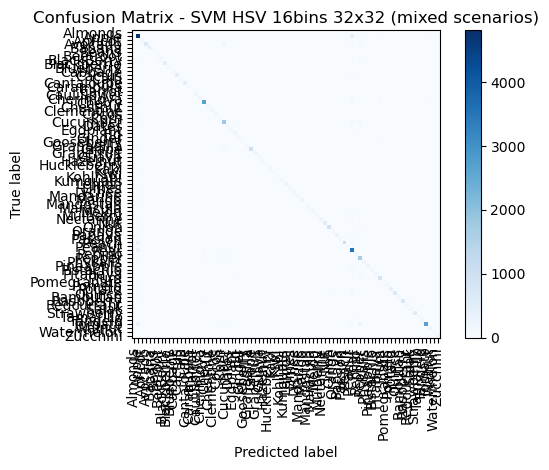

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(y_true_mixed, y_pred_mixed)

plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=target_names
)
disp.plot(include_values=False, xticks_rotation=90, cmap="Blues")
plt.title("Confusion Matrix - SVM HSV 16bins 32x32 (mixed scenarios)")
plt.tight_layout()
plt.show()